# Star Selection Function and Examples

Make the necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
from scipy.spatial import distance
from scipy import spatial
from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from matplotlib.patches import Circle, Wedge, Polygon

Read in the data for the region you wish to analyse. Use the standard methods.
For this example, I will be reading in a region of the sky containing CHAMII and CHAMIII

***Update: This Notebook now uses NGC2264 as an example to test on a more complex region***

In [2]:
#t = Table.read('CHAM_cloud_data.vot',format='votable')
t = Table.read('NGC2264.vot',format='votable')
print(t.colnames) #To be able to know column names within VOTable

RA = t['RA_ICRS']
DEC = t['DE_ICRS']
Gmag = t['__Gmag_']
Source = t['Source']

['_RAJ2000', '_DEJ2000', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var']


First, we define the data that we are going to use in the Analysis.
'data' represents our RA and DEC coordinates for all stars within the region.
'redData' *(Reduced Data)* Represents all stars with Gmag Less than 17  (G <=17)

The following code defines the function "distanceMap'. It will use the KDTree Nearest Neighbor algorithm to create a distance map for all of the stars in the selected region. With this distance map, it will create a contour plot to reveal the 2D structure of the cloud or clouds. It will also define a matrix called 'DistArray', and this matrix will be used for the Star Selection function. 

In [4]:
# def distanceMap(N,data,k):
#     Start = time.time()
    

#     xgrid = np.linspace(np.min(data[:,0]),np.max(data[:,0]),N)
#     ygrid = np.linspace(np.min(data[:,1]),np.max(data[:,1]),N)
#     X, Y = np.meshgrid(xgrid,ygrid)
#     X = np.array(X)
#     Y = np.array(Y)
#     XY = [X,Y]
#     XY = np.transpose(XY)
#     XYcoords = XY[0]
#     for j in range(1,len(XY)):
#         XYcoords = np.vstack((XYcoords,XY[j]))

#     tree = KDTree(data,50)
#     dist,ind = tree.query(XYcoords,k=k)
#     distArray = []
#     for d in range(len(dist)):
#         distArray.append(dist[d][(k-1)])   
#     distArray = np.array(distArray)
#     distArray = np.reshape(distArray,(-1,N))
#     distArray = np.transpose(distArray)

#     fig, ax = plt.subplots()
#     ax.set_facecolor('black')
#     plt.contour(X,Y,distArray,8,cmap='hot')
#     plt.colorbar()
#     plt.xlim(np.min(X),np.max(X))
#     plt.ylim(np.min(Y),np.max(Y))
#     plt.title(str(N)+'x'+str(N)+' Contour Plot')
#     plt.xlabel('RA')
#     plt.ylabel('DEC')
#     plt.gca().invert_xaxis()
#     plt.show()
#     End = time.time()
#     print('Total Runtime: ',End-Start,'s')
    
#     return distArray

In [6]:
# def distance_map(data,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,image, scatter, contour):
#     from scipy.spatial import KDTree

    #use KD tree to find distances to nearest neighbor stars
#     tree = KDTree(data)
    
#     diffRA = (RAmax - RAmin)
#     diffDE = (DEmax - DEmin)
    
#     pixel_count2 = pixel_count
    
#     if (diffRA < diffDE):
#         dDE = diffDE/pixel_count2
#         pixel_count = int(diffRA/dDE)
#         dRA = diffRA/pixel_count
#     if (diffRA > diffDE):
#         dRA = diffRA/pixel_count
#         pixel_count2 = int(diffDE/dRA)
#         dDE = diffDE/pixel_count2
#     if (diffRA == diffDE):
#         dRA = diffRA/pixel_count
#         dDE = diffDE/pixel_count
        
#     #create array of coordinates for image background
#     for i in range(0,pixel_count):
#         for j in range(0,pixel_count2):
#             if (i==0 and j == 0):
#                 array4 = np.array([RAmin,DEmin])
#             else:
#                 array3 = [RAmin+i*dRA,DEmin+j*dDE]
#                 array4 = np.vstack((array4,array3))

#     #find nearest neighbor distances to background points
#     image = tree.query(array4,k=neighbor+1)

#     #change array of background points so it is pixel_count x pixel_count2
#     dist2 = image[0][:,neighbor-1]
#     dist2 = np.resize(dist2,(pixel_count,pixel_count2))
#     dist2 = np.rot90(dist2, k=1, axes=(1,0))
#     dist2 = np.fliplr(dist2)

#     #display map   
#     plt.imshow(dist2, origin='lower',extent=[RAmin,RAmax,DEmin,DEmax])
#     plt.show()
    
#     #contour plot
#     if (contour == True):
#         ct = plt.contourf(dist2, cmap='tab10',extent=[RAmin,RAmax,DEmin,DEmax])
#         plt.colorbar()
#         plt.show()
#     #scatter plot
#     if (scatter == True):
#         plt.scatter(data[:,0],data[:,1],s = 1,c = 'k')
#         plt.show()
#     return dist2

In [3]:
def distance_map(data,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour):
    #Function uses KD Tree to create a distance map and returns pixel counts along both axes, as well as the
    #scale of degrees to pixel for each axis
    
    #Variables Read In
    #data: an array with two columns of stellar coordinates (RA,DEC)
    #pixel_count: number of pixels for large side of image
    #RAmin, RAmax, DEmin, DEmax: min/max coordinates of image
    #neighbor: number of nearest neighbor to calculate
    #scatter: True/False create a scatter plot of the stars
    #contour: True/False create a contour plot of the distance map
    
    #Varables Returned
    #dist2: distance map
    #pixel_count: pixel count along x axis
    #pixel_count2: pixel count along y axis
    #dRA: degrees to pixel scale along x axis (for RA)
    #dDE: degrees to pixel scale along y axis (for Dec)

    from scipy.spatial import KDTree

    #use KD tree to find distances to nearest neighbor stars
    tree = KDTree(data)
    
    #find distances between min/max RA and DE
    diffRA = (RAmax - RAmin)
    diffDE = (DEmax - DEmin)
    
    #make pixel count along x and y axes equal initially
    pixel_count2 = pixel_count
    
    #makes sure that both x and y axes have same scale of degrees to pixel
    if (diffRA < diffDE):
        dDE = diffDE/pixel_count2
        pixel_count = int(diffRA/dDE)
        dRA = diffRA/pixel_count
    if (diffRA > diffDE):
        dRA = diffRA/pixel_count
        pixel_count2 = int(diffDE/dRA)
        dDE = diffDE/pixel_count2
    if (diffRA == diffDE):
        dRA = diffRA/pixel_count
        dDE = diffDE/pixel_count
        
    #create array of coordinates for image background
    for i in range(0,pixel_count):
        for j in range(0,pixel_count2):
            if (i==0 and j == 0):
                array4 = np.array([RAmin,DEmin])
            else:
                array3 = [RAmin+i*dRA,DEmin+j*dDE]
                array4 = np.vstack((array4,array3))

    #find nearest neighbor distances to background points
    image = tree.query(array4,k=neighbor+1)

    #change array of background points so it is pixel_count x pixel_count2
    dist2 = image[0][:,neighbor-1]
    dist2 = np.resize(dist2,(pixel_count,pixel_count2))
    dist2 = np.rot90(dist2, k=1)#, axes=(1,0))  EDIT HERE
    dist2 = np.fliplr(dist2)

    #display map   
    plt.imshow(dist2, origin='lower',extent=[RAmin,RAmax,DEmin,DEmax])
    plt.gca().invert_xaxis()
    plt.show()
    
    #contour plot
    if (contour == True):
        ct = plt.contourf(dist2,extent=[RAmin,RAmax,DEmin,DEmax]) #removed heatmap
        plt.gca().invert_xaxis()
        plt.colorbar()
        plt.show()
    #scatter plot
    if (scatter == True):
        plt.scatter(data[:,0],data[:,1],s = 1,c = 'k')
        plt.gca().invert_xaxis()
        plt.show()
        
    return dist2, pixel_count, pixel_count2, dRA, dDE

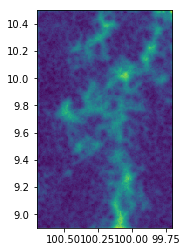

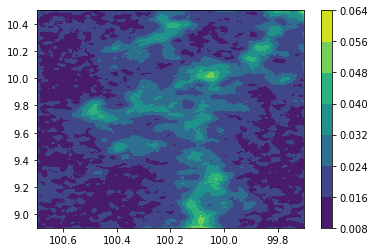

Elapsed time is: 26.489782571792603


In [4]:
import time

num = len(RA)
X1 = np.zeros(num)
Y1 = np.zeros(num)
for i in range(0,num):
    X1[i] = RA[i]
    Y1[i] = DEC[i]
X = np.column_stack((X1,Y1))

RAmin = min(RA)
RAmax = max(RA)
DEmin = min(DEC)
DEmax = max(DEC)
RA_range = RAmax - RAmin
DE_range = DEmax - DEmin
area = RA_range*DE_range
num = len(RA)
density = num/area
start_time = time.time()
    
#range of coordinates
pixel_count = 250
image = False
scatter = False
contour = True
neighbor = 20
# data,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour
distances = distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour)
num = time.time() - start_time
print('Elapsed time is: ' + str(num))


# Star Selection Bug fixes/ Updates

Next, we define the function 'StarSelection' which will allow us to grab all stars located between individual contour lines. This version of the code chooses specific a specific contour at a certain level within the plot. You choose the region by simply inputting a RA and DEC. CrossHairs will appear on the plot illustrating where you are focusing your analysis. 

***Next update will remove the need to specify an RA and DEC value (Make it an optional Parameter).***

In [9]:
def StarSelection(RA,DEC,Source,distArray,L,Gmag,Gvalue=999,specRA=999,specDEC=999):
    
    # ***9 Parameters***
    
    # *1st Parameter* "RA"       :  Array of data containing the RA values for the stars in the region
    # *2nd Parameter* "DEC"      :  Array of data containing the DEC values for the stars in the region
    # *3rd Parameter* "Source"   :  Array of data containing the GAIA ID for each star within the region
    # *4th Parameter* "distArray":  Distance Array created by the distance_map function
    # *5th Parameter* "L"        :  Input the contour level you wish to analyze.
    # *6th Parameter* "Gmag"     :  Array of G Magnitude Values
    # *7th Parameter* "Gvalue    :  Reduces data to all stars with this Gmag value or lower. **Must be decimal/float**
    # *8th Parameter* "specRA"   :  Specific RA location (Optional)
    # *9th Parameter* "specDEC"  :  Specific DEC location (Optional)
    
    # You can get the contour level by looking at the colorbar next to contour plot
    
    # specRA and specDEC are optional parameters. If no RA and DEC are chosen, you will find
    # all stars within the L contour level. If an RA and DEC are chosen, function will
    # grab stars located in a single contour at the L level
    
    # Reduces Star Data based off of user inputted G Mag value
    # Define data array
    data = np.array([RA,DEC])
    if(Gvalue != 999):
        redData = []            
        for i in range(len(Gmag)):
            if(Gmag[i] <= Gvalue):
                redData.append([RA[i],DEC[i],Source[i]])
        redData = np.array(redData) # Will use redData as the stars to be selected within contours
    else:
        max_Gvalue = np.max(Gmag)
        redData = []            
        for i in range(len(Gmag)):
            if(Gmag[i] <= max_Gvalue):
                redData.append([RA[i],DEC[i],Source[i]])
        redData = np.array(redData) # Will use redData as the stars to be selected within contours
    
    Ysize, Xsize = np.shape(distArray) # Calculates X and Y size of distance_map Matrix
    
    
    xgrid = np.linspace(np.min(RA),np.max(RA),Xsize) # Creates grid length in X dir
    ygrid = np.linspace(np.min(DEC),np.max(DEC),Ysize) # Creates grid length in Y dir
    X, Y = np.meshgrid(xgrid,ygrid) # Defines Grid
    X = np.array(X)
    Y = np.array(Y)
    if(specRA != 999 and specDEC != 999):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(14,6)
        ax2.set_facecolor('black')
        ax2.invert_xaxis()
        ax2.contour(X,Y,distances[0])
    else:
        fig, ax1 = plt.subplots()
        fig.set_size_inches(7,6)
    ax1.set_facecolor('black')
    cs = ax1.contour(X,Y,distArray,alpha=0.9,lw=0.6)
    fig.colorbar(cs, ax=ax1)
    ax1.set_xlim([np.min(X),np.max(X)])
    ax1.set_ylim([np.min(Y),np.max(Y)])
    ax1.invert_xaxis()
    
    firstContour = []
    higherContour = []
    insideStars = []
    starCount = 0
    ## The following code will run if user inputs a specifc RA and DEC
    if(specRA != 999 and specDEC != 999):
        G_alpha = 0.6
        size = 5.0
        inside = []
        finalPoly = []
        # get_paths finds every array that contains the (X,Y) points which define each contour at Level L
        for i in range(len(cs.collections[L].get_paths())): # Iterate over each specific array
            p = cs.collections[L].get_paths()[i] # p defines one of these arrays
            v = p.vertices # v contains all (X,Y) points
            x = v[:,0]
            y = v[:,1]
            # If the current array in the loop contains the specific RA and DEC coordinate that the user 
            # inputs, this code will initiate.
            if(specRA >= np.min(x) and specRA <= np.max(x) and specDEC >= np.min(y) and specDEC <= np.max(y)):
                
                ax1.axvline(x=specRA,linestyle='--',color='y',alpha=0.4) # If RA/DEC are inputted, this will plot
                ax1.axhline(y=specDEC,linestyle='--',color='y',alpha=0.4) # a "target" at the coordinate
                ax1.plot(x,y,c='w')
                ax2.plot(x,y,c='w')
                ax2.set_xlim([np.min(x),np.max(x)])
                ax2.set_ylim([np.min(y),np.max(y)])
                ax2.invert_xaxis()
                polygon = v # Creates a Polygon Region from all (X,Y) points in current array
                path = mpltPath.Path(polygon,closed=True) # Creates a path defined by polygon
                inside = path.contains_points(np.transpose([redData[:,0],redData[:,1]])) # *EDITED CODE* Selects all stars located inside path region
                # Inside Array will be a boolean array (True,False). Any star located inside path will
                # have a value of "True"
                finalPoly = [x,y] # Defines the Polygon that contained user inputed RA/DEC
                
                for s in range(len(inside)):
                    if(inside[s] == True): # Find all stars with an associated "True value"
                        firstContour.append(redData[s]) 
    
        # Next, function needs to recognize any higher level contour contained within itself
        finalPoly = np.transpose(np.array(finalPoly)) # Sets proper dimensions
        inside_higher = [] # Will represent stars within a higher level contour 
        for j in range(len(cs.collections[L+1].get_paths())): # All arrays located at L+1 level
            p = cs.collections[L+1].get_paths()[j]
            v = p.vertices
            x = v[:,0]
            y = v[:,1]
            # If current array in loop is inside of the L contour, this code will initiate
            
            if(len(firstContour) > 0 and np.min(x)>=np.min(finalPoly[:,0]) and np.max(x)<=np.max(finalPoly[:,0]) and np.min(y)>=np.min(finalPoly[:,1]) and np.max(y)<=np.max(finalPoly[:,1])):
                polygon = v
                path2 = mpltPath.Path(polygon,closed=True) # defines path of higher level contour
                inside_higher = path2.contains_points(np.transpose([redData[:,0],redData[:,1]])) #EDITED CODE finds all stars inside higher contour
                for s in range(len(inside_higher)):
                    if(inside_higher[s] == True): # find all stars with an associated "True" vale
                        higherContour.append(redData[s])
        higherContour = np.array(higherContour)
        firstContour = np.array(firstContour) # Defines two arrays that have the same length as the 
        # data.  
        
        # The for loop will find all stars that are within the lower contour "firstContour" and outside
        # of the higher contour "higherContour". All stars that match these conditions will be added to
        # insideStars. 
        for s in range(len(firstContour)):
            if(len(higherContour > 0)):
                if(firstContour[s,0] not in higherContour[:,0] and firstContour[s,1] not in higherContour[:,1]):
                #if(firstContour[s,2] not in higherContour[:,2]):
                    insideStars.append(firstContour[s])
            else:
                insideStars.append(firstContour[s])

        insideStars = np.array(insideStars)
        
    ## WITH NO SPECIFIC REGION ON CONTOUR PLOT
    else:
        G_alpha = 0.3
        size = 0.8
        firstContour = []
        higherContour = []
        inside = []
        for j in range(len(cs.collections[L].get_paths())):
                p = cs.collections[L].get_paths()[j]
                v = p.vertices
                x = v[:,0]
                y = v[:,1]
                polygon = v
                path = mpltPath.Path(polygon,closed=True)
                inside = path.contains_points(np.transpose([redData[:,0],redData[:,1]]))
                for i in range(len(inside)):
                    if(inside[i] == True):
                        #starCount = starCount + 1
                        firstContour.append(redData[i])
                if(len(firstContour) > 0): 
                    ax1.plot(x,y,c='w',alpha=1.0,lw=0.7)
        
        for j in range(len(cs.collections[L+1].get_paths())):
            p = cs.collections[L+1].get_paths()[j]
            v = p.vertices
            polygon = v 
            path = mpltPath.Path(polygon,closed=True)
            inside_higher = path.contains_points(np.transpose([redData[:,0],redData[:,1]]))
            for i in range(len(inside_higher)):
                    if(inside_higher[i] == True):
                        starCount = starCount + 1
                        higherContour.append(redData[i])
        higherContour = np.array(higherContour)
        firstContour = np.array(firstContour)
        for s in range(len(firstContour)):
            if(len(higherContour >0)):
                if(firstContour[s,0] not in higherContour[:,0] and firstContour[s,1] not in higherContour[:,1]):
                    insideStars.append(firstContour[s])
            else:
                insideStars.append(firstContour[s])
        insideStars = np.array(insideStars)
    
    if(Gvalue != 999):
        print('Gmag <= ',Gvalue,'\nTotal Stars: ',len(redData))
    else:
        print('No cut-off Gmag value \nTotal Stars: ',len(redData))
    
    ax1.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',alpha=G_alpha,marker='*')
    if(specRA != 999 and specDEC != 999):
        ax2.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',marker='*')
    if(len(insideStars) > 0):
        ax1.scatter(insideStars[:,0],insideStars[:,1],s=1.0,c='r',marker='*')
        if(specRA != 999 and specDEC != 999):
            ax2.scatter(insideStars[:,0],insideStars[:,1],s=15.0,c='r',marker='*')
            ax1.set_title('Plot of Stars Located in Specific Contour')
            ax2.set_title('Magnified Image of Chosen Contour')
            ax2.set_xlabel('RA')
            ax2.set_ylabel('DEC')
            
            # ***** New Code as of 3/8 10:00PM Below ****
#             plt.figure(figsize=(12.5,5))
#             plt.subplot(1, 2, 1)
#             plt.contour(distances[0])

#             plt.subplot(1, 2, 2)
#             plt.plot()
#             plt.xlim(np.min(x),np.max(x))
#             plt.ylim(np.min(y),np.max(y))

        else:
            ax1.set_title('Plot of Stars Located in Chosen Contour Level')
        ax1.set_xlabel('RA')
        ax1.set_ylabel('DEC')
        plt.show()
        print('Total Stars within contour: ',len(insideStars),'\n\n')
        print('Star ID              RA                    DEC\n')
        for i in range(len(insideStars)):
            print(insideStars[i,2],'           ',insideStars[i,0],'            ',insideStars[i,1])
    else:
        print('No Stars Found')
        plt.show()
   
    

Now, here are examples using the Star Selection Function. 

Notice how in the first example, the higher level contour did not get mixed with the lower level contour. All of the stars within the higher contour did not get selected. This is one of the updates that I made to StarSelection

***You also do not need to specify the N value, which reduces the number of inputs required***

The first two examples demonstrate choosing two different layers of contours and specifying an RA and DEC region. Also not that the function recognizes concentric contours. This means that stars within a higher layer will not become mixed with lower level contours. 

Gmag <=  17.0 
Total Stars:  6181


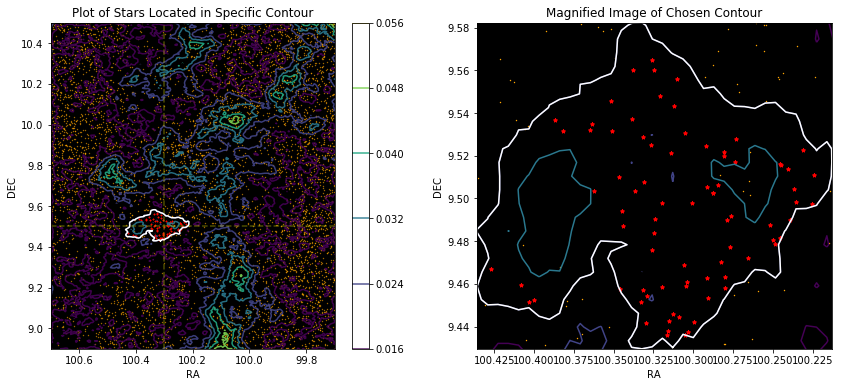

Total Stars within contour:  80 


Star ID              RA                    DEC

32767.0             100.22403355              9.5108111817
32767.0             100.2254522              9.4975150823
32767.0             100.231219246              9.5225090673
32767.0             100.235367843              9.4982693193
32767.0             100.236473473              9.5042072685
32767.0             100.239386117              9.4898175534
32767.0             100.240694031              9.5139833192
32767.0             100.245051778              9.5158365767
32767.0             100.245263718              9.5159641854
32767.0             100.245483109              9.4813540089
32767.0             100.24865285              9.4788091186
32767.0             100.249976284              9.480551895
32767.0             100.252114035              9.4877495816
32767.0             100.265378255              9.4723412793
32767.0             100.273109106              9.5279270697
32767.0             10

In [12]:

StarSelection(RA,DEC,Source,distances[0],1,Gmag,17.0,specRA=100.3,specDEC=9.5)
#StarSelection(RA,DEC,Source,distances[0],2,Gmag,Gvalue=17.0)


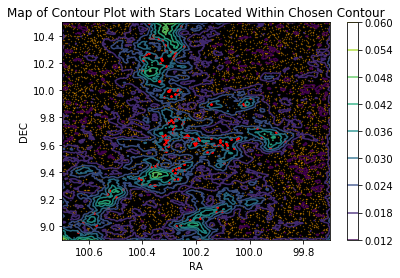

Total Stars within contour:  145 


100.3 10.4
TRUE!
Shape of finalPoly: (2, 304)


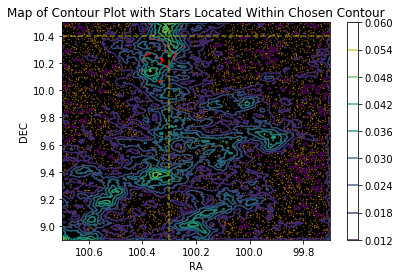

Total Stars within contour:  28 




In [64]:

StarSelection(RA,DEC,Gmag,distances,3)
StarSelection(RA,DEC,Gmag,distances,3,100.3,10.4)



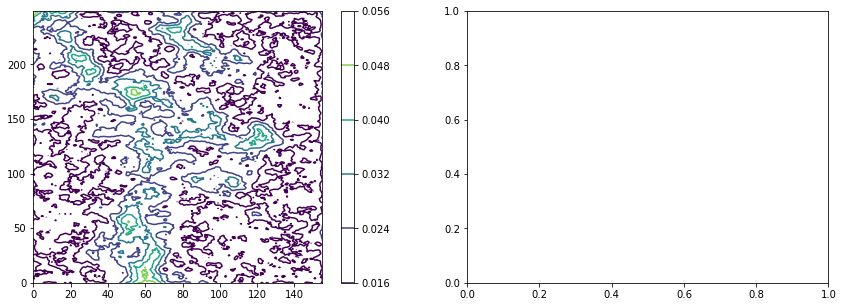

In [257]:
# x = np.linspace(0,1)
# y = np.linspace(0,1)


plt.figure(figsize=(14.25,5))
#plt.figure()
plt.subplot(1, 2, 1)
plt.contour(distances[0])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))

plt.show()

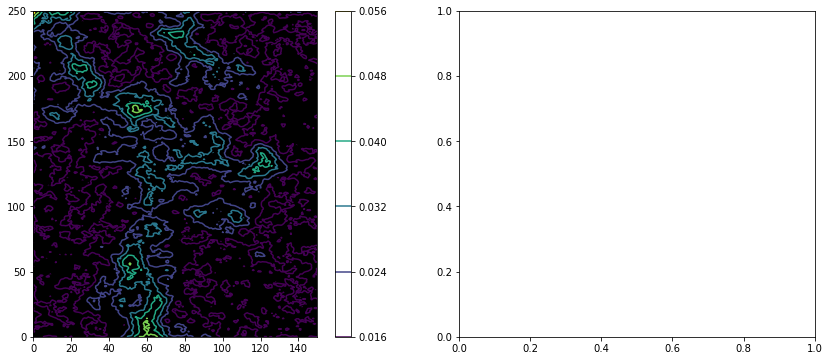

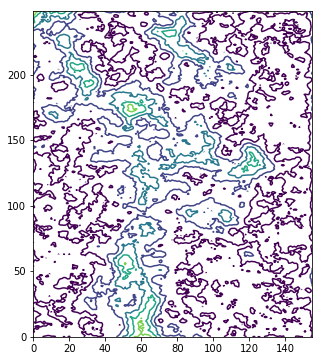

In [336]:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)
z = np.linspace(0,2*np.pi,400)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14,6)
ax1.set_facecolor('black')
cf = ax1.contour(distances[0])
fig.colorbar(cf, ax=ax1)
ax1.set_xlim([0,150])
ax1.set_ylim([0,250])
ax2.axvline(1,1)
ax.set_title('Simple plot')
plt.show()
print('\n\n\n')

fig = plt.gcf()

fig.set_size_inches(5,6)
plt.contour(distances[0])
plt.show()

The next two examples demonstrates the ability to not specify a specific contour on the plot. The only parameters you need to enter are the distance matrix 'distArray' and the contour level. Code still distinguishes between concentric contours.

Beware choosing a contour near the edge of the plot. These contours tend to not close in on themselves. When this happens, stars outside of the desired contour will also be selected. 
Here is an example:

***Example from CHAMII and CHAMIII***